# 1. DATA
You can dowload this here https://github.com/congnghia0609/ntc-scv.git

In [3]:
!git clone https://github.com/congnghia0609/ntc-scv.git

fatal: destination path 'ntc-scv' already exists and is not an empty directory.


# 2. PREPARE TRAIN, VALID, TEST DATASET

In [4]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == 'neg':
                label = 0
            if label == 'pos':
                label = 1
            data = {
                'sentence' : sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)


In [5]:
folder_paths = {
    'train': './ntc-scv/data/data_train/train',
    'valid': './ntc-scv/data/data_train/test',
    'test': './ntc-scv/data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [6]:
train_df.head(10)

,sentence,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0
5,Hôm_nay đến aeon có ghé vào quán . Món ăn cũng...,0
6,"Mình vào lúc 8h tối , cũng không đông khách lắ...",0
7,"Thức_ăn quá_đỗi bình_thường , miếng xôi của bạ...",0
8,"Mình thấy quán này rất được , nhân_viên phục_v...",0
9,Hôm_qua đi ăn cùng 7 chị ở công_ty . Quảng_cáo...,0


# 3. PREPROCESSING TEXT DATA

## 3.1 Language Detection

In [7]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs = True)
    not_vi_idx = set()
    THRESHOLD = 0.9 #  Remove if probability of Vietnamese <= 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row['sentence'])
        if score[0] != 'vi' or (score[0] == 'vi' and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [8]:
# classifer if a sample is written by vietnamese or other language
train_df_vi, train_df_other = identify_vn(train_df)

In [9]:
# vietnamese sentences
train_df_vi

,sentence,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0
...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1


In [10]:
#other language sentences
train_df_other

,sentence,label
446,Minh da den them 1 lan vao buoi trua ma van do...,0
523,The drink taste not good as Shanghai . The tas...,0
582,I work in District 1 not far from Taco_King . ...,0
802,Service is worst . . waiter and waitress messi...,0
809,Day la lan dau cung nhu lan cuoi minh ghe quan...,0
...,...,...
29571,We had high expectations of this place and my ...,1
29687,"My name is Luan , A_Local_Travel_Consultant ...",1
29757,"Art of lanterns , super nice and acceptable pr...",1
29853,The 200k buffet is really worth it ! Good meat...,1


## 3.2 Preprocessing - Remove special symbol and character
1. link https
2. html tag
3. punctuation and digits
4. emoji

In [11]:
import re
import string

def preprocess_text(text):

    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

In [12]:
train_df_vi['sentence'][0]

'Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi hơn 20 \' . Hỏi lại thì nv tl có r nhg bảo chờ thêm 15 \' nữa " tụi e lm liền " .\n Mình k biết có ngon k nhg cũng muốn ăn thử . Thiết_nghĩ nv quán nên xem_lại cách pv và nc vs khách .\n'

In [13]:
# sentence after remove special character
preprocess_text(train_df_vi['sentence'][0])

'mua có mỗi bingsu thập cẩm k mà mình f đợi hơn hỏi lại thì nv tl có r nhg bảo chờ thêm nữa tụi e lm liền mình k biết có ngon k nhg cũng muốn ăn thử thiết nghĩ nv quán nên xem lại cách pv và nc vs khách'

In [14]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

C:\Users\TAN\AppData\Local\Temp\ipykernel_19800\1058621333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [15]:
train_df 

,sentence,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0
...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1


In [16]:
valid_df

,sentence,label,preprocess_sentence
0,Lần đầu_tiên ăn chắc cũng là lần cuối ăn_ở đây...,0,lần đầu tiên ăn chắc cũng là lần cuối ăn ở đây...
1,"Khi mình vào thì bàn chưa dọn , dơ kinh . Cái ...",0,khi mình vào thì bàn chưa dọn dơ kinh cái bếp ...
2,Haiz ! Không biết đúng hương_vị của bánh thế_n...,0,haiz không biết đúng hương vị của bánh thế nào...
3,Mình ghé quán này vì thấy có cơm theo kiểu Việ...,0,mình ghé quán này vì thấy có cơm theo kiểu việ...
4,"Quán xịn ở Quan_Hoa - Cầu_Giấy , biển_hiệu màu...",0,quán xịn ở quan hoa cầu giấy biển hiệu màu xan...
...,...,...,...
9995,"Quán không_gian nhỏ nhưng khá lịch_sự , sạch_s...",1,quán không gian nhỏ nhưng khá lịch sự sạch sẽ ...
9996,đi ăn lần 2 : ) ) ) lần này rút kinh_nghiệm ki...,1,đi ăn lần lần này rút kinh nghiệm kiu đồ ăn ít...
9997,"Mình ăn 2 món , mà quên tên mất rồi , toàn từ ...",1,mình ăn món mà quên tên mất rồi toàn từ cá hồi...
9998,Trong ảnh là\n • 1 phần mì udon xào\n • 1 phần...,1,trong ảnh là • phần mì udon xào • phần cuốn ki...


In [17]:
test_df

,sentence,label,preprocess_sentence
0,Quán này khá là nổi_tiếng nay mới có dịp ghé t...,0,quán này khá là nổi tiếng nay mới có dịp ghé t...
1,"Đây là lần đầu_tiên mình ăn_ở đây , và có_lẽ c...",0,đây là lần đầu tiên mình ăn ở đây và có lẽ cũn...
2,tha ́ i đô ̣ phu ̣ c vu ̣ nhân_viên không tô ́...,0,tha ́ i đô ̣ phu ̣ c vu ̣ nhân viên không tô ́...
3,Đồ_ăn bình_thường . Cần chăm_chút không_gian h...,0,đồ ăn bình thường cần chăm chút không gian hơn...
4,"Phục_vụ lâu , giá thì ổn thôi nhưng chất_lượng...",0,phục vụ lâu giá thì ổn thôi nhưng chất lượng b...
...,...,...,...
9995,"Gia re , mon an ngon , view dep va nhan vien n...",1,gia re mon an ngon view dep va nhan vien nhiet...
9996,"Quán nằm trên đường Thạch_Thị_Thanh , dễ tìm ....",1,quán nằm trên đường thạch thị thanh dễ tìm khô...
9997,Mình đã đến ăn_ở quán này vài lần . Đồ_ăn ngon...,1,mình đã đến ăn ở quán này vài lần đồ ăn ngon g...
9998,Nhà_hàng trang_trí độc_đáo .\n Món ăn mới_lạ n...,1,nhà hàng trang trí độc đáo món ăn mới lạ nhiều...


## 4. EDA

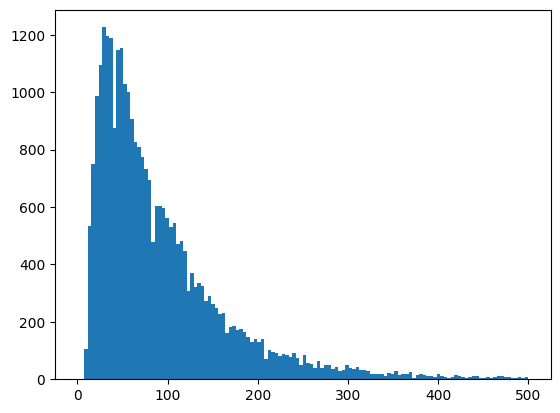

In [18]:
import matplotlib.pyplot as plt 

plt.hist([len(sentence.split()) for sentence in train_df_vi['preprocess_sentence']], bins=128, range=(0, 500))
plt.show()

In [19]:
# dictionary of words
from collections import Counter

words = []
[[words.append(word) for word in sentence.split()] for sentence in train_df_vi['preprocess_sentence']]
vocabulary = Counter(words)
len(vocabulary), len(words)

(17244, 2856797)

## 5. TEXT REPRESENTATION

In [20]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [21]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [22]:
tokenizer(train_df_vi['preprocess_sentence'][0])[:5]

['mua', 'có', 'mỗi', 'bingsu', 'thập']

In [23]:
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=['<unk>']
)
vocabulary.set_default_index(vocabulary['<unk>'])

In [24]:
len(vocabulary)

10000

In [25]:
print(vocabulary(tokenizer(train_df_vi['preprocess_sentence'][0])))

[140, 3, 205, 890, 913, 856, 13, 15, 2, 2556, 241, 76, 186, 20, 7, 369, 2495, 3, 565, 1280, 213, 282, 96, 56, 419, 606, 2777, 659, 2, 13, 120, 3, 10, 13, 1280, 9, 175, 1, 98, 648, 331, 369, 6, 17, 287, 20, 189, 1375, 8, 689, 277, 60]


### Encoding word

In [26]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)


In [27]:
print(next(iter(train_dataset)))

([140, 3, 205, 890, 913, 856, 13, 15, 2, 2556, 241, 76, 186, 20, 7, 369, 2495, 3, 565, 1280, 213, 282, 96, 56, 419, 606, 2777, 659, 2, 13, 120, 3, 10, 13, 1280, 9, 175, 1, 98, 648, 331, 369, 6, 17, 287, 20, 189, 1375, 8, 689, 277, 60], 0)


In [28]:
len(train_dataset)

29736

## 6. DataLoader

In [29]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    encoded_sentences, labels, offsets = [], [], [0]
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)
        offsets.append(encoded_sentence.size(0))

    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    encoded_sentences = torch.cat(encoded_sentences)
    return encoded_sentences.to(device), offsets.to(device), labels.to(device)

In [30]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [31]:
next(iter(train_dataloader))

(tensor([1732, 1022,    3,  ..., 1508,  994, 3890]),
 tensor([    0,    68,   153,   183,   488,   708,   779,   965,   988,  1039,
          1095,  1153,  1186,  1273,  1686,  1751,  1778,  1941,  2037,  2079,
          2159,  2171,  2198,  2256,  2289,  2390,  2431,  2510,  2622,  2722,
          2851,  3034,  3110,  3315,  3362,  3491,  3584,  3618,  3680,  3726,
          3746,  3770,  3876,  3890,  4290,  4455,  4558,  4672,  4717,  4821,
          5060,  5135,  5429,  5851,  6198,  6297,  6319,  6403,  6478,  6495,
          6569,  6659,  6683,  6712,  6748,  6782,  6944,  7009,  7113,  7164,
          7233,  7279,  7456,  7504,  7667,  7741,  7768,  7872,  7935,  8019,
          8056,  8087,  8167,  8481,  8519,  8542,  8616,  8666,  8709,  8772,
          8877,  8964,  9063,  9148,  9193,  9250,  9365,  9388,  9567,  9748,
          9770,  9819, 10082, 10188, 10353, 10430, 10483, 10648, 10862, 10904,
         11119, 11154, 11174, 11193, 11280, 11497, 12187, 12323, 12386, 12460,

In [32]:
encoded_sentences, offsets, labels = next(iter(train_dataloader))
encoded_sentences.shape

torch.Size([12042])

## 7. Model

In [33]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        init_range = 0.5
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.fc(embedded)

In [34]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

In [35]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(10000, 100, mode='mean')
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [36]:
predictions = model(encoded_sentences, offsets)

In [37]:
predictions

tensor([[-2.4487e-02, -3.7482e-02],
        [ 1.6719e-01,  2.5853e-01],
        [-8.7694e-02, -1.6508e-01],
        [ 1.7879e-02, -1.0283e-01],
        [ 1.0484e-02, -4.4918e-02],
        [ 2.2029e-01, -1.6051e-01],
        [ 9.8016e-02,  6.3497e-02],
        [-5.2466e-03, -5.1928e-02],
        [-3.4659e-02, -9.5296e-03],
        [ 1.2535e-01, -4.1647e-02],
        [-2.6246e-01, -4.7053e-02],
        [-5.3380e-02, -2.4186e-01],
        [ 3.9319e-02, -1.4148e-01],
        [ 7.5890e-03,  3.0800e-02],
        [ 3.3180e-02, -9.3648e-02],
        [-6.6626e-02,  1.0332e-01],
        [ 9.8772e-03, -3.3431e-01],
        [ 5.1465e-03, -1.8627e-01],
        [ 1.4687e-01, -8.7642e-02],
        [-3.4735e-02, -2.2289e-02],
        [ 1.0854e-01, -2.0321e-01],
        [ 1.9091e-02,  3.1496e-02],
        [ 3.7637e-02, -8.9038e-02],
        [ 5.4750e-02,  1.8644e-01],
        [ 1.6688e-01, -4.1808e-02],
        [-1.2509e-01, -2.4826e-01],
        [-1.3462e-01, -8.0897e-02],
        [ 3.0771e-02, -1.024

In [38]:
learning_rate = 2e-5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [39]:
loss = criterion(predictions, labels)
loss

tensor(0.6864, grad_fn=<NllLossBackward0>)

# 8. Trainer

In [40]:
import time

def train(model, optimizer, criterion, train_dataloader, epoch=0, log_interval=25):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, offsets, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model(inputs, offsets)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [41]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader)

| epoch   0 |    25/  233 batches | accuracy    0.527
| epoch   0 |    50/  233 batches | accuracy    0.522
| epoch   0 |    75/  233 batches | accuracy    0.524
| epoch   0 |   100/  233 batches | accuracy    0.512
| epoch   0 |   125/  233 batches | accuracy    0.497
| epoch   0 |   150/  233 batches | accuracy    0.532
| epoch   0 |   175/  233 batches | accuracy    0.512
| epoch   0 |   200/  233 batches | accuracy    0.526
| epoch   0 |   225/  233 batches | accuracy    0.508


In [42]:
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, offsets, labels) in enumerate(valid_dataloader):
            predictions = model(inputs, offsets)
            loss = criterion(predictions, labels)
            losses.append(loss)
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [43]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)

In [44]:
eval_acc, eval_loss

(0.5156, tensor(0.6927))

# 9. Training

In [45]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

learning_rate = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, epoch)
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

| epoch   1 |    25/  233 batches | accuracy    0.594
| epoch   1 |    50/  233 batches | accuracy    0.729
| epoch   1 |    75/  233 batches | accuracy    0.787
| epoch   1 |   100/  233 batches | accuracy    0.818
| epoch   1 |   125/  233 batches | accuracy    0.820
| epoch   1 |   150/  233 batches | accuracy    0.828
| epoch   1 |   175/  233 batches | accuracy    0.829
| epoch   1 |   200/  233 batches | accuracy    0.844
| epoch   1 |   225/  233 batches | accuracy    0.834
-----------------------------------------------------------
| End of epoch   1 | Time:  2.34s | Train Accuracy    0.854 | Train Loss    0.463 | Valid Accuracy    0.849 | Valid Loss    0.393 
-----------------------------------------------------------
| epoch   2 |    25/  233 batches | accuracy    0.851
| epoch   2 |    50/  233 batches | accuracy    0.851
| epoch   2 |    75/  233 batches | accuracy    0.860
| epoch   2 |   100/  233 batches | accuracy    0.857
| epoch   2 |   125/  233 batches | accuracy   

# 10. Prediction

In [46]:
model = model.to('cpu')

In [47]:
def predict(text):
    with torch.no_grad():
        encoded = torch.tensor(vocabulary(tokenizer(text)))
        output = model(encoded, torch.tensor([0]))
        return output.argmax(1).item()

In [48]:
test_df.iloc[0]

sentence               Quán này khá là nổi_tiếng nay mới có dịp ghé t...
label                                                                  0
preprocess_sentence    quán này khá là nổi tiếng nay mới có dịp ghé t...
Name: 0, dtype: object

In [49]:
predict(test_df.iloc[0]['sentence'])

0

In [50]:
# compute accuracy on test set

predictions, labels = [], []
for index, row in test_df.iterrows():
    sentence = row['preprocess_sentence']
    label = row['label']
    prediction = predict(sentence)
    predictions.append(prediction)
    labels.append(label)

print('Accuracy: ', sum(torch.tensor(predictions) == torch.tensor(labels))/len(labels))

Accuracy:  tensor(0.8722)
